In [1]:
from mynn import *
prefix = "uniform-100-160/"
# prefix = "uniform-250-300/"
θ, κ = preprocess_data(prefix)

# from 115-140
θ, κ = θ[151:401], κ[:,:,151:401]
# 250, 250.2, 250.4 ... 300
θ_train, κ_train = θ[0::2], κ[:, :,  0::2]
# 250.1, 250.3, 250.5 ... 299.9
θ_test, κ_test = θ[1::2], κ[:, :,  1::2]
# θ_test, κ_test = θ[1::2], κ[:, :,  0::2]

data_svd, bases, N_trunc = build_bases(κ_train, acc=0.9999)


x_train = torch.from_numpy(θ_train.astype(np.float32)).unsqueeze(-1) 
y_train = torch.from_numpy(data_svd.astype(np.float32))

N_trunc =  5


In [2]:
N_θ = 1
model = DirectKernelRomNet(N_θ, N_trunc)
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


n_epochs = 100000
for epoch in range(n_epochs):
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelRomNet.model")

	
# save the model
torch.save(model, "DirectKernelRomNet.model")

[0/100000], loss: 4747.516
[10000/100000], loss: 1.136
[20000/100000], loss: 1.137
[30000/100000], loss: 1.135
[40000/100000], loss: 1.135
[50000/100000], loss: 1.135
[60000/100000], loss: 1.136
[70000/100000], loss: 0.086
[80000/100000], loss: 0.077
[90000/100000], loss: 0.088


In [3]:
x_train.shape

model.fc2

Linear(in_features=20, out_features=20, bias=True)

In [4]:
######################################################
N_θ = 1
N_data  =  θ_test.shape
N_x, N_y, N_data = κ_test.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

model = torch.load("DirectKernelRomNet.model")
κ_pred = model(torch.from_numpy(θ_test.astype(np.float32)).unsqueeze(-1)).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]  , bases).reshape(N_x, N_y)

test_ids = np.arange(0, N_data)
errors = np.zeros(len(test_ids))



Average error is  0.07391030364165496


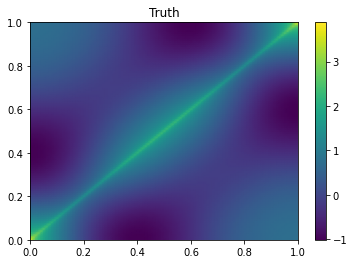

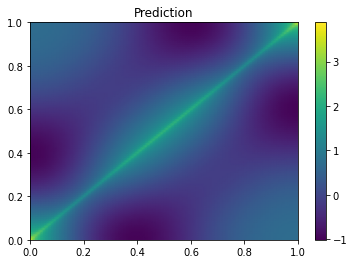

In [5]:
for test_id in test_ids:

    errors[test_id] =  np.linalg.norm(κs_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if test_id %249 == 0:
        vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % test_id)

print("Average error is ", np.average(errors))




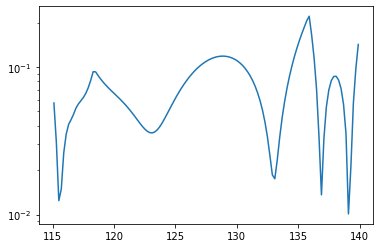

In [6]:

plt.semilogy(np.linspace(115+0.1, 140-0.1, len(errors)), errors)

<ipython-input-7-a45296ef77b2>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, bases[i, :].reshape(N_x, N_y), vmin=vmin, vmax=vmax, cmap="gray")


<Figure size 432x288 with 0 Axes>

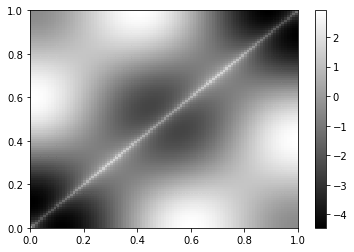

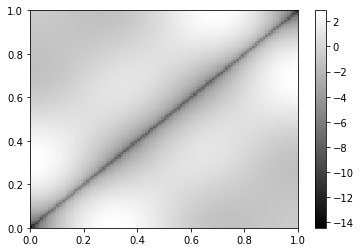

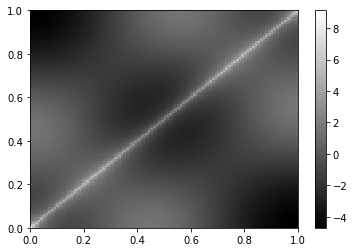

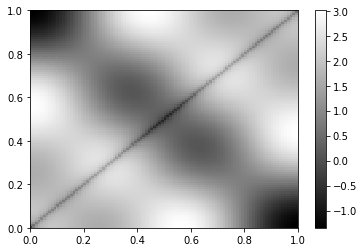

In [7]:
L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)
N_x, N_y, N_data = κ_test.shape
vmin, vmax = None, None
fig = plt.figure()
for i in range(4):
    plt.figure()
    plt.pcolormesh(X, Y, bases[i, :].reshape(N_x, N_y), vmin=vmin, vmax=vmax, cmap="gray")
    plt.colorbar()

        
